In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import math
from math import radians, sin, cos, sqrt
import os
import geopandas as gpd
import psycopg2
import ast
import matplotlib.pyplot as plt
import datetime
from psycopg2 import sql
from psycopg2.extras import Json
from shapely.geometry import LineString, mapping, box, Polygon, Point
from shapely import wkt
from shapely.wkb import loads
import shapely
import json
from myutil import *
import scipy
import myutil
import pickle
import pyproj


from geopy.distance import great_circle
from scipy.spatial import KDTree, cKDTree
from sklearn.neighbors import NearestNeighbors
#from pykdtree.kdtree import KDTree
from sklearn.neighbors import BallTree
import sklearn.neighbors
import pykdtree
import rtree 
import pyqtree 
import quads
from quads import QuadTree
from pygeos import STRtree

d:\NewOne\UQ\INFS4205\assignment\taxi_trajectory\venv\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Acer\AppData\Local\Temp\ipykernel_20396\311580122.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:/

In [2]:
df = pd.read_csv("final_data.csv")

In [3]:
try:
    # connect to the database
    connection = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="taxi_trajectory",
    user="postgres",
    password="123456"
    )
    cursor = connection.cursor()
    print("Connected!")
except print(0):
    print("Connect error!")

Connected!


In [4]:
select_start_end_points_query = "SELECT trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom FROM taxi_trips"
cursor.execute(select_start_end_points_query)
rows = cursor.fetchall()

In [4]:
#select_all_points_query = """SELECT trip_id, lon, lat FROM points"""
#cursor.execute(select_all_points_query)
#all_points = cursor.fetchall()

# Query:  Find the trajectory that is shortest (NOT fastest) from given data point to another.


I omitted the fastest path through 2 points because the data is not normalized. In other words, I can assume the taxi moves at a constant speed between 2 pairs of coordinates, but in real data (or this dataset), the taxi can stop or slow down in some sections of the road (for waiting red light, traffic jam, etc), while the GPS time is collected for each pair of coordinates is 15 seconds apart (it means unequal distance between coordinate pairs even though it is recorded correctly every 15 seconds). Therefore, it makes no sense to find the fastest path based on the total time taken in the preprocessing step. Instead, I focused on the total distance of each taxi trip to determine the shortest road. If we can find the shortest path, we can implicitly assume it can be the fastest.

Explain my approach:
- I will find all the {start_points}/{end_points} in the rectangular area 50 meters from a given point. The returned points' {trip_ids} are the trips passing through that 2 regions.
- Then I'll use linear search to find the minimum distance.

NOTE: Task 5 is find the linestrings being similar. For easier implementation, I define the similarity of 2 linestrings is start and end at the same region. Therefore, I can combine the code with task 4 below

## Init 

In [27]:
target_start_point = (-8.6291126, 41.1573266)
target_end_point = (-8.6503384, 41.1756372)
distance_range = 100 # meter
distance_range_km = distance_range / 1000

In [7]:
target_start_point[0]

-8.6291126

In [5]:
def translate_latlong(lat, long, lat_translation_meters, long_translation_meters):
    ''' method to move any lat,long point by provided meters in lat and long direction.
    params :
        lat,long: lattitude and longitude in degrees as decimal values, e.g. 41.15554, -8.6348530
        lat_translation_meters: movement of point in meters in lattitude direction.
                                positive value: up move, negative value: down move
        long_translation_meters: movement of point in meters in longitude direction.
                                positive value: left move, negative value: right move
        '''
    earth_radius = 6378.137

    #Calculate top, which is lat_translation_meters above
    m_lat = (1 / ((2 * math.pi / 360) * earth_radius)) / 1000;  
    lat_new = lat + (lat_translation_meters * m_lat)

    #Calculate right, which is long_translation_meters right
    m_long = (1 / ((2 * math.pi / 360) * earth_radius)) / 1000;  # 1 meter in degree
    long_new = long + (long_translation_meters * m_long) / math.cos(lat * (math.pi / 180));
    
    return lat_new,long_new

In [30]:
lat_translation_meters = long_translation_meters = distance_range
print(lat_translation_meters)
start_region_plus_lat, start_region_plus_long = translate_latlong(target_start_point[1], target_start_point[0], lat_translation_meters, long_translation_meters)
start_region_minus_lat, start_region_minus_long = translate_latlong(target_start_point[1], target_start_point[0], -lat_translation_meters, -long_translation_meters)

print(start_region_plus_long, start_region_plus_lat)
print(start_region_minus_long, start_region_minus_lat)

end_region_plus_lat, end_region_plus_long = translate_latlong(target_end_point[1], target_end_point[0], lat_translation_meters, long_translation_meters)
end_region_minus_lat, end_region_minus_long = translate_latlong(target_end_point[1], target_end_point[0], -lat_translation_meters, -long_translation_meters)

# define start and end region bounds
start_region_bounds = (start_region_minus_long, start_region_minus_lat, start_region_plus_long, start_region_plus_lat)
end_region_bounds = (end_region_minus_long, end_region_minus_lat, end_region_plus_long, end_region_plus_lat)

100
-8.627919466320524 41.15832491528412
-8.630305733679474 41.15652828471588


In [31]:
# start region
plot_point_and_bounding_box(target_start_point[0], target_start_point[1], start_region_minus_long, start_region_minus_lat, start_region_plus_long, start_region_plus_lat)

In [32]:
plot_point_and_bounding_box(target_end_point[0], target_end_point[1], end_region_minus_long, end_region_minus_lat, end_region_plus_long, end_region_plus_lat)

# Query

In [33]:
# Create R-tree index
p = rtree.index.Property()
p.dimension = 2  # Three dimensions: x, y (bounding box)
myrtree = rtree.index.Index(properties=p)

In [35]:
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    geom = loads(geom_wkt)
    minx, miny, maxx, maxy = geom.bounds
    bounds = (minx, miny,maxx, maxy)
    myrtree.insert(int(trip_id), bounds)
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
rtree_creation_time = t2 - t1

Execution time: 0:03:12.879039


In [58]:
def rtree_query_intersect(query_bounds):
    t1 = datetime.datetime.now()
    retured_trip_ids_rtree = myrtree.intersection(query_bounds)
    t2 = datetime.datetime.now()
    print("myrtree intersection Execution time:", t2 - t1)
    rtree_query_time = t2-t1
    
    retured_trip_ids_rtree = set(retured_trip_ids_rtree)
    return retured_trip_ids_rtree, rtree_query_time
    """
    filtered_trip_ids = set()
    t1 = datetime.datetime.now()
    for trip_id in retured_trip_ids_rtree:
        idx = df[df['trip_id'] == trip_id].index[0]
        coords = shapely.wkt.loads(df.geom[idx]).coords
        within_bounds = [(coords[i][0] >= query_bounds[0] and coords[i][1] >= query_bounds[1]) 
                         and (coords[i][0] <= query_bounds[2] and coords[i][1] <= query_bounds[3]) 
                         for i in range(len(coords))]
        if any(within_bounds):
            filtered_trip_ids.add(df.trip_id[idx])
    t2 = datetime.datetime.now()
    print("Filtered results Execution time:", t2 - t1)
    rtree_query_time += t2 - t1
    print("Total query time:", rtree_query_time)
    return filtered_trip_ids, rtree_query_time
    """

In [92]:
def trip_ids_filter(trip_ids, start_region_bounds, end_region_bounds):
    """
    Filter for taxis that actually go into 2 regions, then calculate the shortest distance.

    Args:
        trip_ids (list): trip IDs to be filtered.
        start_region_bounds (tuple): containing the bounds of the start region [xmin, ymin, xmax, ymax].
        end_region_bounds (tuple): containing the bounds of the end region [xmin, ymin, xmax, ymax].

    Returns:
        tuple: A tuple containing the filtered trip IDs, filtered distances, and query filter time.

    Example:
        trip_ids = [1, 2, 3, 4, 5]
        start_bounds = (-8.123, 41.321, -8.001, 42.123)
        end_bounds = (-8.321, 41.123, -8.222, 42.321)
        filtered_trip_ids, filtered_distances, query_filter_time = trip_ids_filter(trip_ids, start_bounds, end_bounds)

    """
    filtered_trip_ids = set()
    filtered_distances = set()
    filtered_start_region_trip_ids = set()
    filtered_end_region_trip_ids = set()
    t1 = datetime.datetime.now()
    for trip_id in trip_ids:
        idx = df[df['trip_id'] == trip_id].index[0]
        coords = shapely.wkt.loads(df.geom[idx]).coords
        
        forward_distance = float('inf')   # from start to end region
        backward_distance = float('inf')  # from end to start region
        fw_distances = []
        bw_distances = []
        previous_coord = ()
        is_within_start_bounds = False
        is_within_end_bounds = False
        for i in range(len(coords)):
            is_within_start_bounds_local = (coords[i][0] >= start_region_bounds[0] and coords[i][1] >= start_region_bounds[1]) and \
                (coords[i][0] <= start_region_bounds[2] and coords[i][1] <= start_region_bounds[3])
           
            is_within_end_bounds_local = (coords[i][0] >= end_region_bounds[0] and coords[i][1] >= end_region_bounds[1]) and \
                (coords[i][0] <= end_region_bounds[2] and coords[i][1] <= end_region_bounds[3])

            if is_within_start_bounds_local:
                is_within_start_bounds = True
            if is_within_end_bounds_local:
                is_within_end_bounds = True
                
            if i > 0:
                distance = great_circle(coords[i], previous_coord).kilometers
                forward_distance += distance
                backward_distance += distance
                
            if is_within_start_bounds_local:
                if (backward_distance != 0.0 and backward_distance != float('inf')):
                    bw_distances.append(backward_distance)
                forward_distance = 0.0
                    
            if is_within_end_bounds_local:
                if (forward_distance != 0.0 and forward_distance != float('inf')):
                    fw_distances.append(forward_distance)        
                backward_distance = 0.0       
            
            previous_coord = coords[i]    
                
        if is_within_start_bounds and is_within_end_bounds:
            if fw_distances and bw_distances:
                filtered_distances.add(min(min(fw_distances), min(bw_distances)))
            elif fw_distances:
                filtered_distances.add(min(fw_distances))    
            elif bw_distances:
                filtered_distances.add(min(bw_distances))  
                  
            filtered_trip_ids.add(df.trip_id[idx])
    
    t2 = datetime.datetime.now()
    print("Filtered results Execution time:", t2 - t1)
    query_filter_time = t2 - t1
    return filtered_trip_ids, filtered_distances, query_filter_time

In [ ]:
# Check returned ids
create_map4(df['polyline'][df[df['trip_id'] == 1381012847620000279].index.to_list()[0]], [start_region_minus_lat, start_region_minus_long], [start_region_plus_lat, start_region_plus_long])

In [64]:
rtree_returned_start_region_trip_ids, rtree_start_region_query_time = rtree_query_intersect(start_region_bounds)
print("Number of trip_ids:", len(rtree_returned_start_region_trip_ids))

myrtree intersection Execution time: 0:00:00.104106
Number of trip_ids: 259775


In [44]:
len(rtree_returned_start_region_trip_ids)

97394

In [65]:
rtree_returned_end_region_trip_ids, rtree_end_region_query_time = rtree_query_intersect(end_region_bounds)
print("Number of trip_ids:", len(rtree_returned_end_region_trip_ids))

myrtree intersection Execution time: 0:00:00.053856
Number of trip_ids: 118266


In [66]:
# take trip_ids appear in both regions
common_ids = rtree_returned_end_region_trip_ids.intersection(rtree_returned_start_region_trip_ids)
print(len(common_ids))

62219


In [93]:
rtree_returned_trip_ids, filter_distances, filter_query_time = trip_ids_filter(common_ids, start_region_bounds, end_region_bounds)
print(len(rtree_returned_trip_ids))
print(len(filter_distances))
print("Filter Execution time:", filter_query_time)

Filtered results Execution time: 0:02:25.255407
1108
1108
Filter Execution time: 0:02:25.255407


In [97]:
total_query_time = rtree_start_region_query_time + rtree_end_region_query_time + filter_query_time
print("Total query time:", total_query_time)

Total query time: 0:02:25.413369


In [94]:
rtree_returned_trip_ids = list(rtree_returned_trip_ids)
filter_distances = list(filter_distances)
for i in range(len(rtree_returned_trip_ids)):
    print("Trip id:", rtree_returned_trip_ids[i], "  Distance:", filter_distances[i])

Trip id: 1384924682620000256   Distance: 4.135724040999075
Trip id: 1391592162620000256   Distance: 3.923354105359259
Trip id: 1384934422620000256   Distance: 3.4802305991574527
Trip id: 1387815474620000258   Distance: 3.9035177822026625
Trip id: 1386991378620000260   Distance: 4.309377779489526
Trip id: 1374666886620000261   Distance: 3.900433486236241
Trip id: 1375998254620000260   Distance: 5.767502231153807
Trip id: 1381760110620000261   Distance: 5.428278325260984
Trip id: 1388135202620000263   Distance: 3.9381217723712227
Trip id: 1382619114620000271   Distance: 3.8877732339613758
Trip id: 1387820870620000271   Distance: 3.3845499085850728
Trip id: 1379081266620000271   Distance: 3.8797506567825604
Trip id: 1387001138620000276   Distance: 4.524219361755761
Trip id: 1382317114620000285   Distance: 5.867724730057247
Trip id: 1385313354620000285   Distance: 7.413142062190451
Trip id: 1393005038620000296   Distance: 13.238029964249414
Trip id: 1375734126620000303   Distance: 3.952190

In [108]:
# Sort the distances in ascending order
sorted_distances = sorted(filter_distances)

# Take the first 5 trip_ids having shortest distances
for i in range(5):
    index = filter_distances.index(sorted_distances[i])
    trip_id = rtree_returned_trip_ids[index]
    print("Trip id:", trip_id, "  Distance:", sorted_distances[i], "  Total distance of the trip:", df[df.trip_id == trip_id]['distance'].values[0])

Trip id: 1376563663620000020   Distance: 3.094632581021631   Total distance of the trip: 5.39380595880285
Trip id: 1384008055620000255   Distance: 3.1011338020727823   Total distance of the trip: 7.480665189951337
Trip id: 1378267384620000031   Distance: 3.1145306498627536   Total distance of the trip: 3.966917765273031
Trip id: 1373547499620000120   Distance: 3.1243352311513153   Total distance of the trip: 14.058031625520462
Trip id: 1385739045620000047   Distance: 3.166492902512093   Total distance of the trip: 4.149331488914523


In [111]:
create_map5(df['polyline'][df[df['trip_id'] == 1376563663620000020].index.to_list()[0]], 
            [start_region_minus_lat, start_region_minus_long], [start_region_plus_lat, start_region_plus_long],
            [end_region_minus_lat, end_region_minus_long], [end_region_plus_lat, end_region_plus_long]
)

## Linear scan

Don't run this if you don't wanna wait for a very LONGGGGGGGGGGGGGGGGGGGGG time

In [113]:
print(start_region_bounds)
print(end_region_bounds)

(-8.630305733679474, 41.15652828471588, -8.627919466320524, 41.15832491528412)
(-8.651531865316112, 41.17473888471588, -8.64914493468389, 41.176535515284115)


In [114]:
all_trip_ids = []
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, start_long, start_lat, end_long, end_lat, geom_wkt = row
    all_trip_ids.append(trip_id)

linear_returned_trip_ids, linear_filter_distances, linear_filter_query_time = trip_ids_filter(all_trip_ids, start_region_bounds, end_region_bounds)
  
t2 = datetime.datetime.now()
print(len(linear_returned_trip_ids))
print(len(linear_filter_distances))
print("Filter Execution time:", linear_filter_query_time)  
print("Execution time:", t2 - t1)
linear_scan_query_time = t2 - t1

Filtered results Execution time: 0:31:30.381463
1108
1108
Filter Execution time: 0:31:30.381463
Execution time: 0:31:35.530149


In [120]:
linear_filter_distances = list(linear_filter_distances)
linear_returned_trip_ids = list(linear_returned_trip_ids)
# Sort the distances in ascending order
linear_sorted_distances = sorted(linear_filter_distances)

# Take the first 5 trip_ids having shortest distances
for i in range(5):
    index = linear_filter_distances.index(linear_sorted_distances[i])
    trip_id = linear_returned_trip_ids[index]
    print("Trip id:", trip_id, "  Distance:", linear_sorted_distances[i], "  Total distance of the trip:", df[df.trip_id == trip_id]['distance'].values[0])


Trip id: 1376563663620000020   Distance: 3.094632581021631   Total distance of the trip: 5.39380595880285
Trip id: 1384008055620000255   Distance: 3.1011338020727823   Total distance of the trip: 7.480665189951337
Trip id: 1378267384620000031   Distance: 3.1145306498627536   Total distance of the trip: 3.966917765273031
Trip id: 1373547499620000120   Distance: 3.1243352311513153   Total distance of the trip: 14.058031625520462
Trip id: 1385739045620000047   Distance: 3.166492902512093   Total distance of the trip: 4.149331488914523


In [141]:
create_map5(df['polyline'][df[df['trip_id'] == 1373547499620000120].index.to_list()[0]], 
            [start_region_minus_lat, start_region_minus_long], [start_region_plus_lat, start_region_plus_long],
            [end_region_minus_lat, end_region_minus_long], [end_region_plus_lat, end_region_plus_long]
)

# Performance evaluation

The performance of this query mainly bases on the filter() function, other costs (creating indecies and finding the points within a rectangle) are same as task 1. I used linear scan to check is the taxi really go to the searching bounding boxes or not (same as task 1). I think there's no more efficient way to do this task, because the total of points is more than 49 million points, we have to trade this data storage capacity if we want to increase query performance. The worst case is O(n^2)

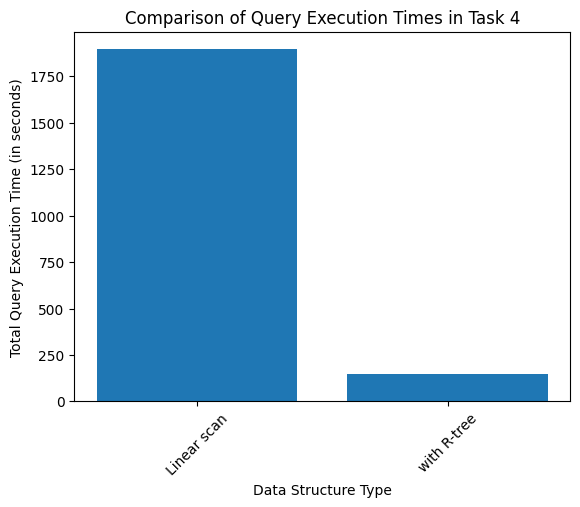

In [119]:
query_time_all = {'Linear scan': linear_scan_query_time.total_seconds(),
                  'with R-tree': total_query_time.total_seconds() }
                  
plt.bar(query_time_all.keys(), query_time_all.values())

plt.xlabel('Data Structure Type')
plt.ylabel('Total Query Execution Time (in seconds)')
plt.title('Comparison of Query Execution Times in Task 4')
plt.xticks(rotation=45)
plt.show()